### EDA

In [5]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import regex as re

sns.set_style(style = 'whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Import Data

In [6]:
df = pickle.load(open("../assets/combined_subreddits.pkl", "rb"))

In [7]:
df.head()

title   selftext  \
0                                 Late Night Laundry  [removed]   
1             Why Did The Moon Disappear? [Part One]  [removed]   
2                  You don't die of old age (Part 1)  [removed]   
3  Why Did The Moon Disappear? [True Story] (part...  [removed]   
4                                   The Door To Hell        NaN   

                                     title_self_text  created_utc subreddit  
0                        Late Night Laundry[removed]   1580239970   nosleep  
1    Why Did The Moon Disappear? [Part One][removed]   1580239486   nosleep  
2         You don't die of old age (Part 1)[removed]   1580239395   nosleep  
3  Why Did The Moon Disappear? [True Story] (part...   1580238771   nosleep  
4                                                NaN   1580237605   nosleep

In [8]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
nan_filler = 'DELETE_THIS_PLACEhHOLDER_SUPER_OBScURE-492929435'

df.fillna(value = nan_filler, inplace = True)

In [10]:
df.isnull().sum().sum()

0

#### Create new column `all_text` that combines `title` and `selftext` columns.

In [11]:
df['all_text'] = df['title'] + ' ' + df['selftext']

In [12]:
df['all_text'] = df['all_text'].str.replace(nan_filler, '')
df['all_text'].isnull().sum()

0

#### Create new columns `char_count` and `word_count` to look at distributions.

In [13]:
df['char_count'] = df['all_text'].map(lambda x: len(x))
df['char_count']

0         28
1         48
2         43
3         61
4         17
        ... 
19993     70
19994     48
19995    262
19996    715
19997     36
Name: char_count, Length: 19998, dtype: int64

In [14]:
df['word_count'] = df['all_text'].map(lambda x: len(x.split()))
df['word_count']

0          4
1          8
2          9
3         10
4          4
        ... 
19993      9
19994      6
19995     48
19996    135
19997      4
Name: word_count, Length: 19998, dtype: int64

In [15]:
# Drop rows whose character count value is less than 10
df.drop(df[df['char_count'] < 10].index, inplace=True)

In [16]:
# Drop excess columns
df.drop(columns=['title', 'selftext', 'title_self_text'], inplace=True)

In [17]:
df.head()

created_utc subreddit                                           all_text  \
0   1580239970   nosleep                       Late Night Laundry [removed]   
1   1580239486   nosleep   Why Did The Moon Disappear? [Part One] [removed]   
2   1580239395   nosleep        You don't die of old age (Part 1) [removed]   
3   1580238771   nosleep  Why Did The Moon Disappear? [True Story] (part...   
4   1580237605   nosleep                                  The Door To Hell    

   char_count  word_count  
0          28           4  
1          48           8  
2          43           9  
3          61          10  
4          17           4

In [18]:
df.shape

(19798, 5)

In [19]:
# Rearrange order of columns (just a preference)
df = df.reindex(columns=['all_text', 'subreddit', 'char_count', 'word_count', 'created_utc'])

In [20]:
df.head()

all_text subreddit  char_count  \
0                       Late Night Laundry [removed]   nosleep          28   
1   Why Did The Moon Disappear? [Part One] [removed]   nosleep          48   
2        You don't die of old age (Part 1) [removed]   nosleep          43   
3  Why Did The Moon Disappear? [True Story] (part...   nosleep          61   
4                                  The Door To Hell    nosleep          17   

   word_count  created_utc  
0           4   1580239970  
1           8   1580239486  
2           9   1580239395  
3          10   1580238771  
4           4   1580237605

#### Assign target (subreddit) values.

In [21]:
df['subreddit'].value_counts()

nosleep        9991
creepypasta    9807
Name: subreddit, dtype: int64

In [22]:
# Replace subreddit target to 'nosleep':1 and 'creepypasta' :0
df['subreddit'] = [1 if i == 'nosleep' else 0 for i in df['subreddit']]
df['subreddit'].value_counts()

1    9991
0    9807
Name: subreddit, dtype: int64

### Quick Distributions

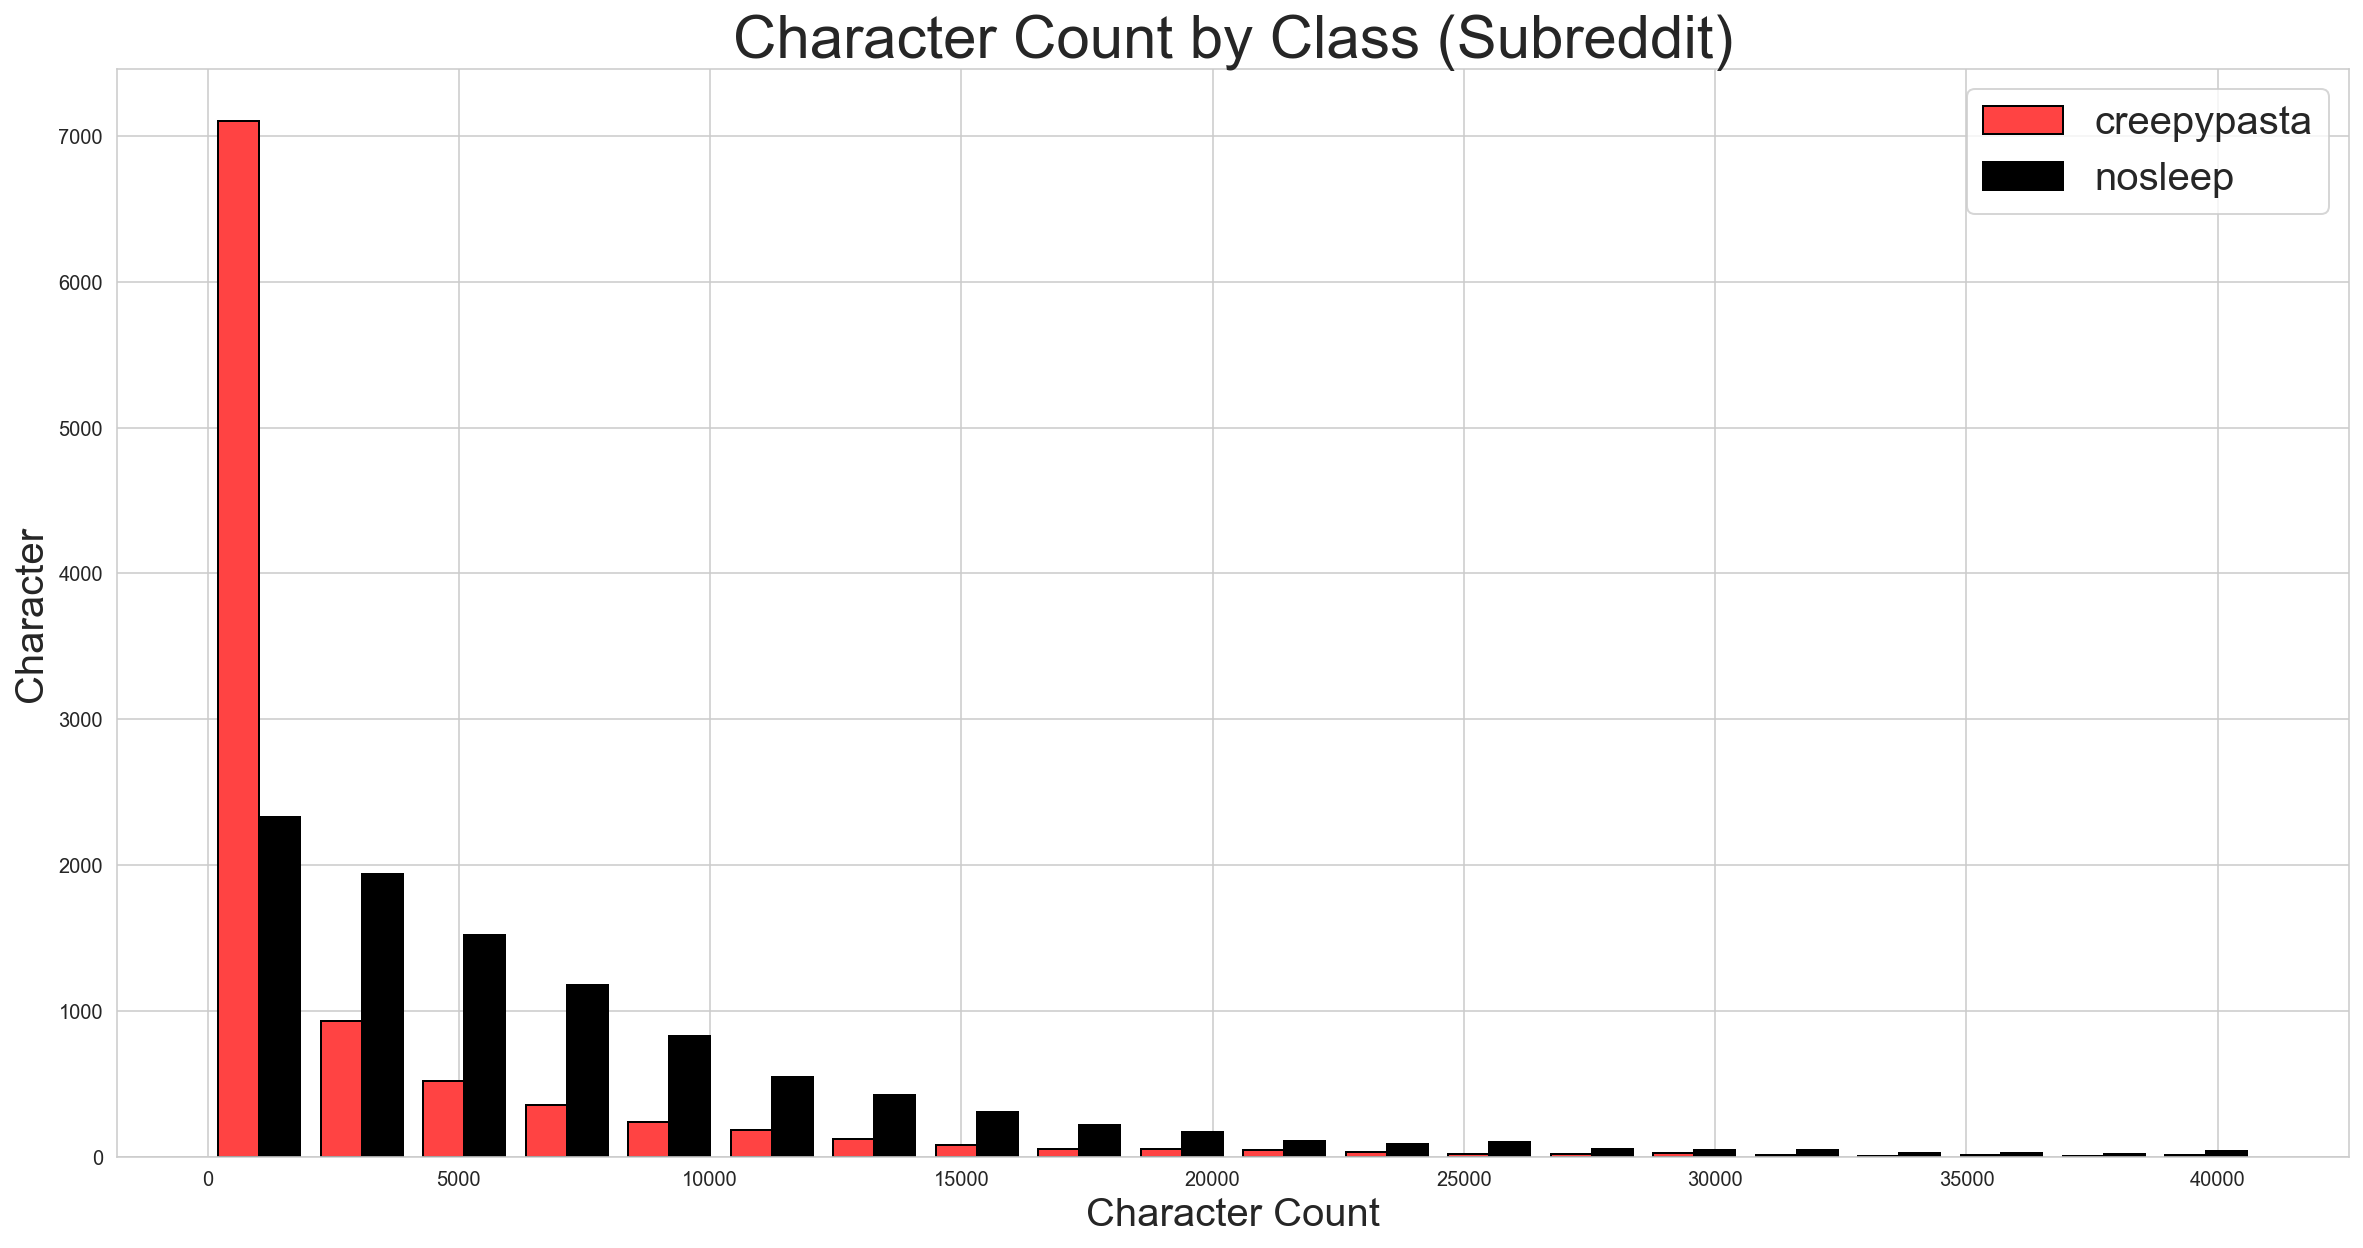

In [23]:
plt.figure(figsize=(20,10))
plt.hist([df[df['subreddit']==0]['char_count'], 
          df[df['subreddit']==1]['char_count']],
         bins=20, color=['#FF4343', 'black'], ec='k')
plt.title('Character Count by Class (Subreddit)', fontsize=30)
plt.xlabel('Character Count', fontsize =20)
plt.ylabel('Character', fontsize =20)
plt.legend(['creepypasta', 'nosleep'], fontsize =20);

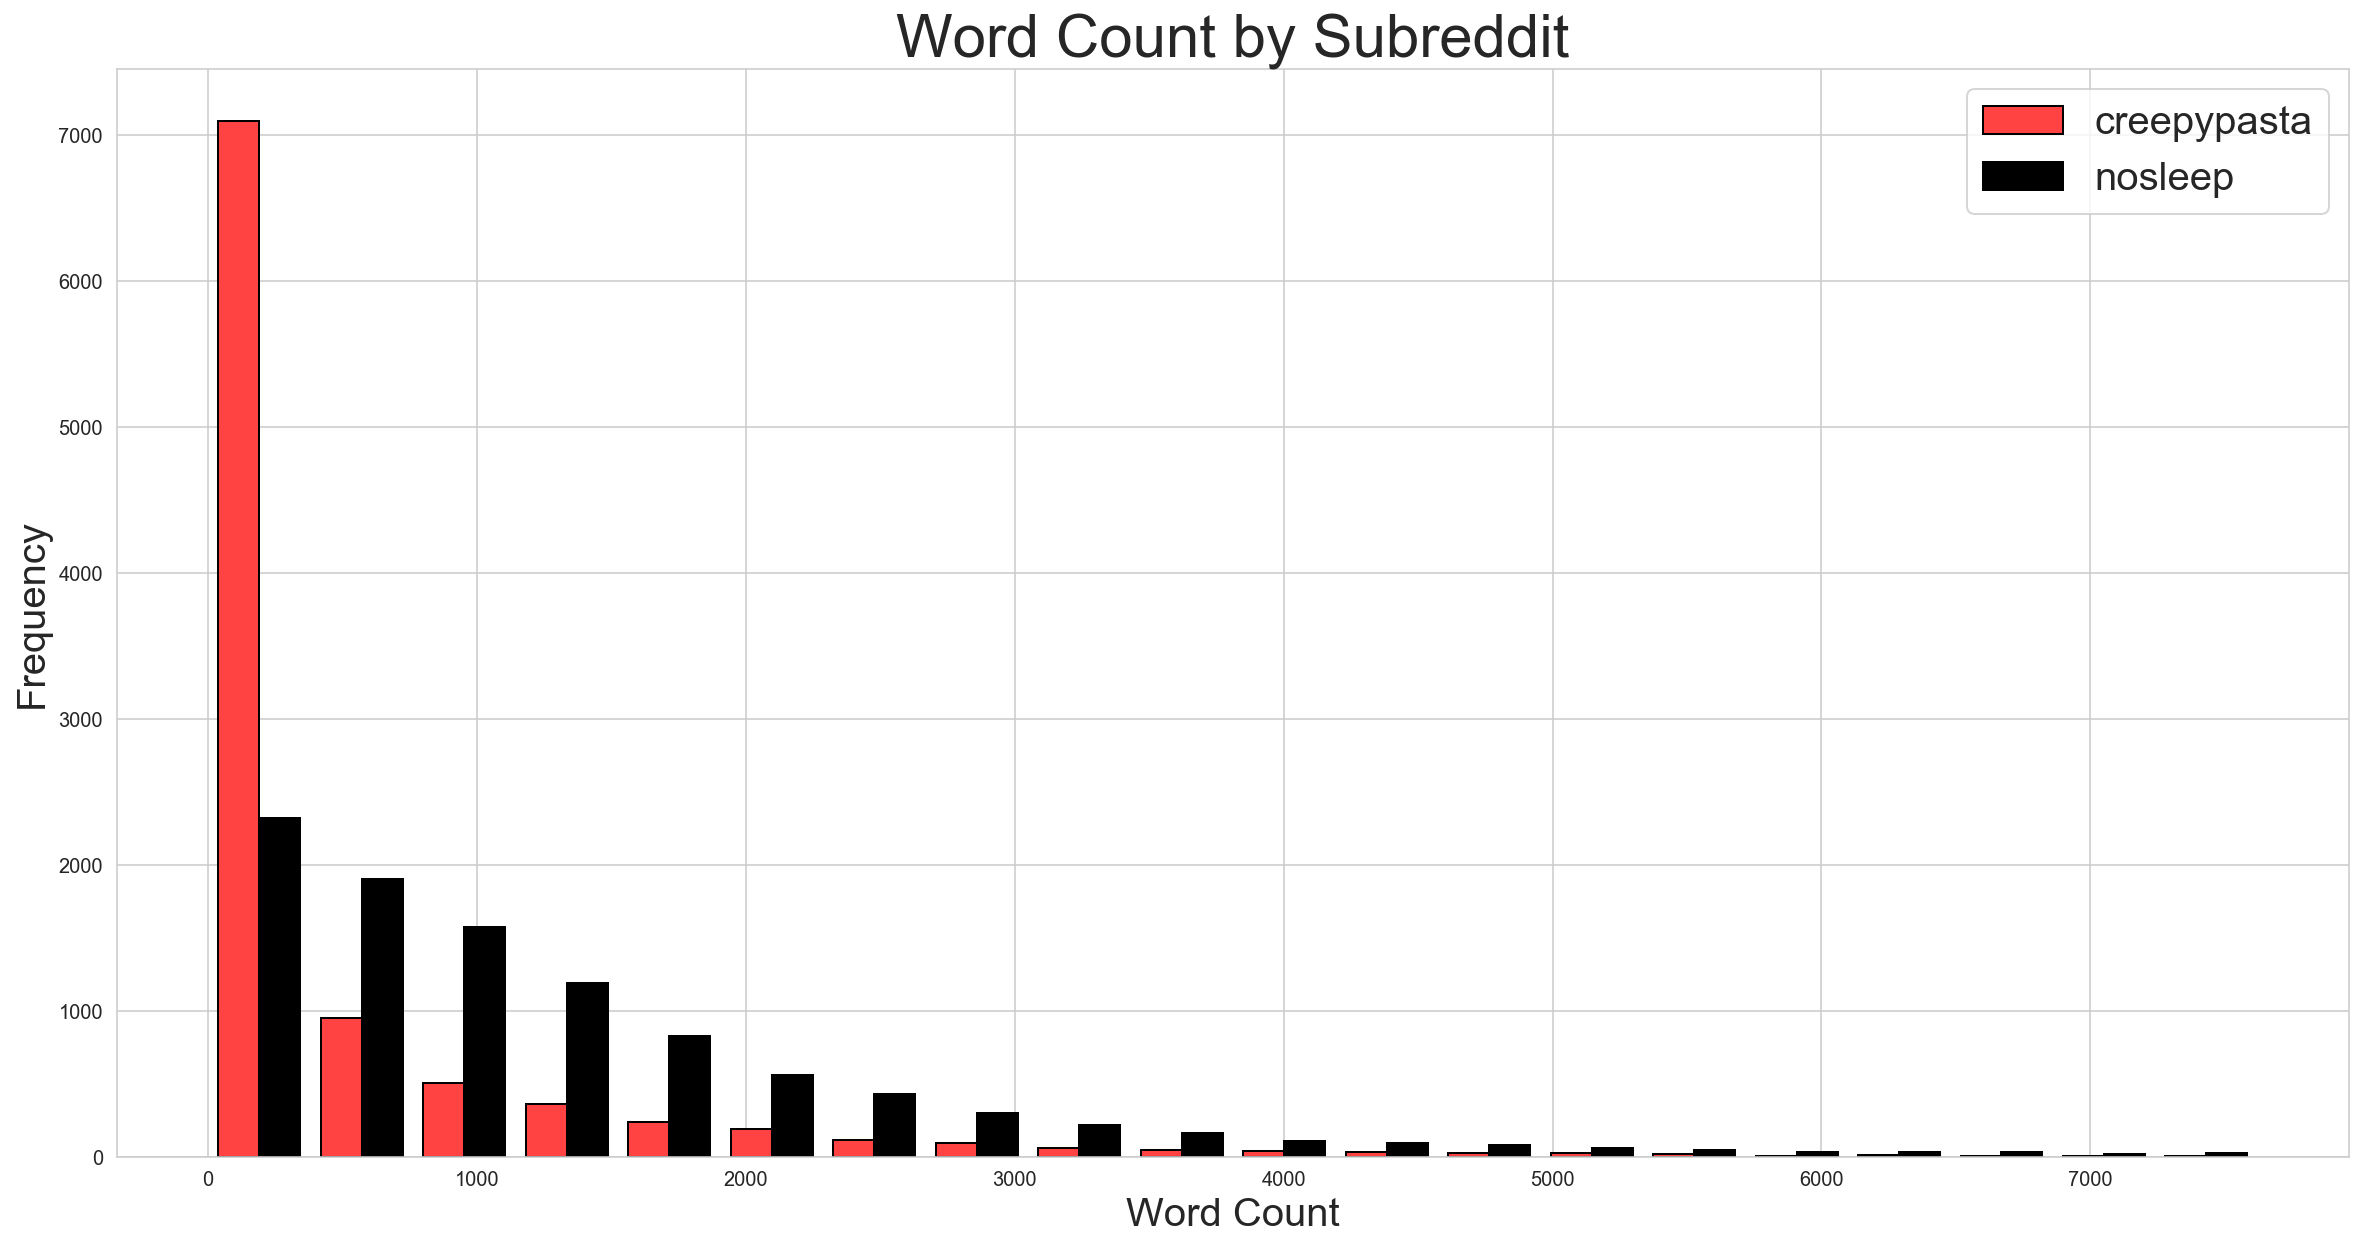

In [24]:
plt.figure(figsize=(20,10))
plt.hist([df[df['subreddit']==0]['word_count'], 
          df[df['subreddit']==1]['word_count']],
         bins=20, color=['#FF4343', 'black'], ec='k')
plt.title('Word Count by Subreddit', fontsize=30)
plt.xlabel('Word Count', fontsize =20)
plt.ylabel('Frequency', fontsize =20)
plt.legend(['creepypasta', 'nosleep'], fontsize =20);
plt.savefig('../images/word_count.png')

### Clean `all_text`:
- Remove punctuation
- Remove numbers
- Remove line breaks
- Remove mentions of target subreddits

In [25]:
# Reset indices
df.reset_index(drop=True, inplace=True)

In [26]:
# Remove '[removed]' which occurs when the selftext was removed from the subreddit
df['all_text'] = df['all_text'].str.replace('\[removed\]', '')

In [27]:
# Check that '[removed]' was removed
df['all_text'].str.contains('\[removed\]').sum()

0

In [28]:
# Make all_text column lowercase
df['all_text'] = df['all_text'].map(lambda x: str.lower(x))

In [29]:
# Remove target subreddit from all_text
df['all_text'] = df['all_text'].str.replace('nosleep', '')

In [30]:
# Remove target subreddit from all_text
df['all_text'] = df['all_text'].str.replace('creepypasta', '')

In [31]:
# Removing or converting subreddit specific words
df['all_text'] = df['all_text'].str.replace('reddit', '')
df['all_text'] = df['all_text'].str.replace('youtube', '')
df['all_text'] = df['all_text'].str.replace('utm', '')
df['all_text'] = df['all_text'].str.replace('oc', 'original content')
df['all_text'] = df['all_text'].str.replace('source', '')
df['all_text'] = df['all_text'].str.replace('slender man', 'slenderman')

In [32]:
df['all_text'] = df['all_text'].str.replace('pasta', '')

In [33]:
df['all_text'] = df['all_text'].str.replace('creepy', '')

In [34]:
# Removing line break
df['all_text'] = df['all_text'].map(lambda x: re.sub('\n', ' ', x)) 

In [35]:
# Removing line breaks
df['all_text'] = df['all_text'].map(lambda x: re.sub('\/\/', ' ', x)) 

In [36]:
# Removing apostrophes
df['all_text'] = df['all_text'].map(lambda x: re.sub('[\\][\']', '', x)) 

In [37]:
# Removing urls
df['all_text'] = df['all_text'].map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x))

In [38]:
# Removing all punctuation 
df['all_text'] = df['all_text'].map(lambda x: re.sub('[^\w\s]', ' ', x)) 

In [39]:
# Removing mentions of any subreddit
df['all_text'] = df['all_text'].map(lambda x: re.sub('\s[\/]?r\/[^\s]+', ' ', x)) 

In [40]:
# Only keeps letters
df['all_text'] = df['all_text'].map(lambda x: re.sub("[^a-zA-Z]", " ", x)) 

In [41]:
df['all_text'] = df['all_text'].map(lambda x: re.sub('z{3,20}', ' ', x)) 

In [42]:
df['all_text'] = df['all_text'].map(lambda x: re.sub('a{3,20}', ' ', x)) 

In [43]:
df['all_text'] = df['all_text'].map(lambda x: re.sub('sh{3,20}', 'shh', x)) 

In [44]:
df['all_text'] = df['all_text'].map(lambda x: re.sub('\s{3,50}', ' ', x)) 

In [45]:
df[df['all_text'].str.contains('aaa')]

Empty DataFrame
Columns: [all_text, subreddit, char_count, word_count, created_utc]
Index: []

In [46]:
df[df['all_text'].str.contains('zzz')]

Empty DataFrame
Columns: [all_text, subreddit, char_count, word_count, created_utc]
Index: []

In [47]:
df[df['all_text'].str.contains('shh')]

all_text  subreddit  \
132     it s not time  this happened a couple of year...          1   
164    my grandfather spoke dozens of languages  his ...          1   
248    my wife talks in her sleep  what she says some...          1   
250    ixodida  the tick a dry husk of a tick floated...          1   
404    i heard the saxophone of erich zann excuse me ...          1   
...                                                  ...        ...   
19403  goosebumps lost episode  surviving horrorland ...          0   
19487  doriginal contenttor black the nightmares have...          0   
19577  the best one night stand of my life sweet smok...          0   
19581  im afraid of eye contact i stood frozen in pla...          0   
19737  hope can kill hope can kill there was a girl n...          0   

       char_count  word_count  created_utc  
132          2113         428   1580154670  
164         16823        3123   1580136828  
248         13074        2398   1580066952  
250         11101        1941   1580065038  
404         32705        6119   1579969195  
...           ...         ...          ...  
19403       16691        3012   1551229161  
19487        2327         479   1550988496  
19577        4300         825   1550773476  
19581        4796         914   1550762283  
19737        7417        1430   1550356379  

[194 rows x 5 columns]

In [48]:
df['all_text']

0                                      late night laundry 
1                    why did the moon disappear  part one 
2                           you dont die of old age  part 
3        why did the moon disappear  true story  part o...
4                                        the door to hell 
                               ...                        
19793          scary stories horror stories  amp readings 
19794                they never learn  by ipostatmidnight 
19795    do i pay for hi  im starting a polish language...
19796    ddd now this beast has been let loose  and not...
19797                                happy valentines day 
Name: all_text, Length: 19798, dtype: object

In [49]:
df.head()

all_text  subreddit  char_count  \
0                                late night laundry           1          28   
1              why did the moon disappear  part one           1          48   
2                     you dont die of old age  part           1          43   
3  why did the moon disappear  true story  part o...          1          61   
4                                  the door to hell           1          17   

   word_count  created_utc  
0           4   1580239970  
1           8   1580239486  
2           9   1580239395  
3          10   1580238771  
4           4   1580237605

In [50]:
df[['char_count', 'word_count']].describe()

char_count    word_count
count  19798.000000  19798.000000
mean    4657.868977    864.606576
std     6446.761594   1185.867372
min       10.000000      1.000000
25%       63.000000     11.000000
50%     2561.500000    493.000000
75%     6748.750000   1254.000000
max    40795.000000   7622.000000

### Remove more stopwords from list above

In [139]:
# Make list to remove more stopwords as they are top words for both but don't add much to classifying
remove = ['got', 'amp', 'said', 'know', 'time', 'just', 'like', 'did', 
          'went', 'way', 'think', 'thought', 'saw', 'going', 'im', 'came', 
          'right', 'looked', 'saw', 'going', 'don', 'started', 'really', 'make']

# Loop through text to find and remove these instances
for i in remove:
    df['all_text'] = df['all_text'].str.replace(i, '')

df['all_text'].str.contains('think').sum()

0

#### Pickle clean DataFrame

In [140]:
pickle.dump(df, open('../assets/clean_df.pkl', 'wb'))

### CountVec for `all_text`

In [141]:
df = pickle.load(open('../assets/clean_df.pkl', 'rb'))

In [142]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

In [143]:
cvec = CountVectorizer(stop_words='english', min_df=5, max_df=1.0)

In [144]:
text = cvec.fit_transform(df['all_text'])

In [145]:
len(cvec.get_feature_names())

30386

In [146]:
text_df = pd.DataFrame(text.toarray(), columns=cvec.get_feature_names())

In [147]:
text_df.head()

aa  aah  aand  aaron  aarons  aas  ab  aback  aban  abaned  ...  zones  \
0   0    0     0      0       0    0   0      0     0       0  ...      0   
1   0    0     0      0       0    0   0      0     0       0  ...      0   
2   0    0     0      0       0    0   0      0     0       0  ...      0   
3   0    0     0      0       0    0   0      0     0       0  ...      0   
4   0    0     0      0       0    0   0      0     0       0  ...      0   

   zoning  zoo  zoologist  zoom  zoomed  zooming  zooms  zozo  zs  
0       0    0          0     0       0        0      0     0   0  
1       0    0          0     0       0        0      0     0   0  
2       0    0          0     0       0        0      0     0   0  
3       0    0          0     0       0        0      0     0   0  
4       0    0          0     0       0        0      0     0   0  

[5 rows x 30386 columns]

In [148]:
text_df.insert(0, 'subredd', df['subreddit'])

In [149]:
text_df.head()

subredd  aa  aah  aand  aaron  aarons  aas  ab  aback  aban  ...  zones  \
0        1   0    0     0      0       0    0   0      0     0  ...      0   
1        1   0    0     0      0       0    0   0      0     0  ...      0   
2        1   0    0     0      0       0    0   0      0     0  ...      0   
3        1   0    0     0      0       0    0   0      0     0  ...      0   
4        1   0    0     0      0       0    0   0      0     0  ...      0   

   zoning  zoo  zoologist  zoom  zoomed  zooming  zooms  zozo  zs  
0       0    0          0     0       0        0      0     0   0  
1       0    0          0     0       0        0      0     0   0  
2       0    0          0     0       0        0      0     0   0  
3       0    0          0     0       0        0      0     0   0  
4       0    0          0     0       0        0      0     0   0  

[5 rows x 30387 columns]

### Distributions

In [150]:
text_df.groupby('subredd').mean()

aa       aah    aand     aaron   aarons     aas        ab  \
subredd                                                                    
0        0.000612  0.000204  0.0000  0.002243  0.00051  0.0000  0.000816   
1        0.003103  0.000601  0.0005  0.032329  0.00020  0.0005  0.001702   

            aback      aban    abaned  ...     zones    zoning       zoo  \
subredd                                ...                                 
0        0.002753  0.003569  0.047211  ...  0.000918  0.000510  0.002447   
1        0.013512  0.012311  0.089080  ...  0.001301  0.001601  0.024922   

         zoologist      zoom    zoomed   zooming     zooms      zozo        zs  
subredd                                                                         
0         0.000102  0.001530  0.002243  0.001835  0.000408  0.000306  0.000102  
1         0.000601  0.002803  0.007006  0.003003  0.001501  0.000601  0.000500  

[2 rows x 30386 columns]

In [151]:
text_df.groupby('subredd').sum()

aa  aah  aand  aaron  aarons  aas  ab  aback  aban  abaned  ...  \
subredd                                                              ...   
0         6    2     0     22       5    0   8     27    35     463  ...   
1        31    6     5    323       2    5  17    135   123     890  ...   

         zones  zoning  zoo  zoologist  zoom  zoomed  zooming  zooms  zozo  zs  
subredd                                                                         
0            9       5   24          1    15      22       18      4     3   1  
1           13      16  249          6    28      70       30     15     6   5  

[2 rows x 30386 columns]

In [152]:
text_df.groupby('subredd').mean().T.sort_values(0, ascending=False).head(20)

subredd         0         1
door     0.750076  2.197878
eyes     0.747221  2.111801
room     0.693382  1.936343
man      0.646885  1.511160
night    0.626491  1.608047
day      0.575201  1.459614
house    0.551443  1.490241
face     0.537779  1.460514
head     0.508922  1.493444
felt     0.504640  1.582524
people   0.501377  1.394355
heard    0.482818  1.314483
thing    0.479351  1.415174
look     0.430407  1.312581
little   0.427552  1.324592
told     0.427552  1.285457
left     0.414704  1.241718
home     0.406138  1.139325
life     0.395840  1.028826
nt       0.395636  1.115004

In [153]:
top_words_creepypasta = text_df.groupby('subredd').mean().T.sort_values(0, ascending=False).head(10)

top_words_nosleep = text_df.groupby('subredd').mean().T.sort_values(1, ascending=False).head(10)

Text(0.5, 1.0, 'creepypasta Top 10 Words')

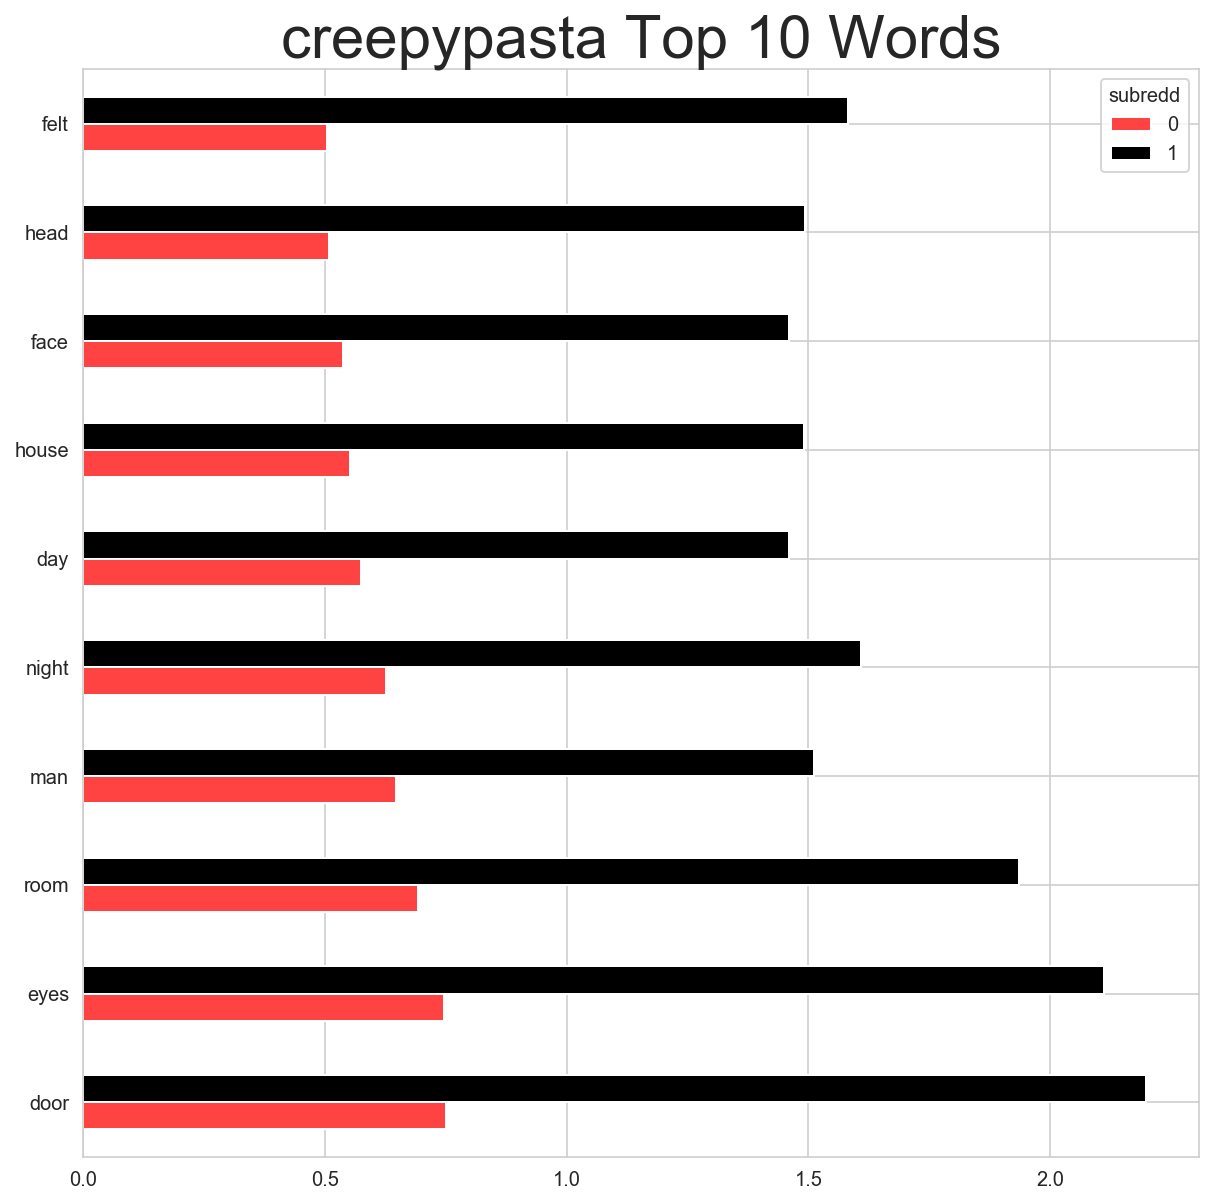

In [154]:
top_words_creepypasta.plot(kind='barh', figsize = (10,10), color = ['#FF4343', 'black'])
plt.title('creepypasta Top 10 Words', fontsize = 30)

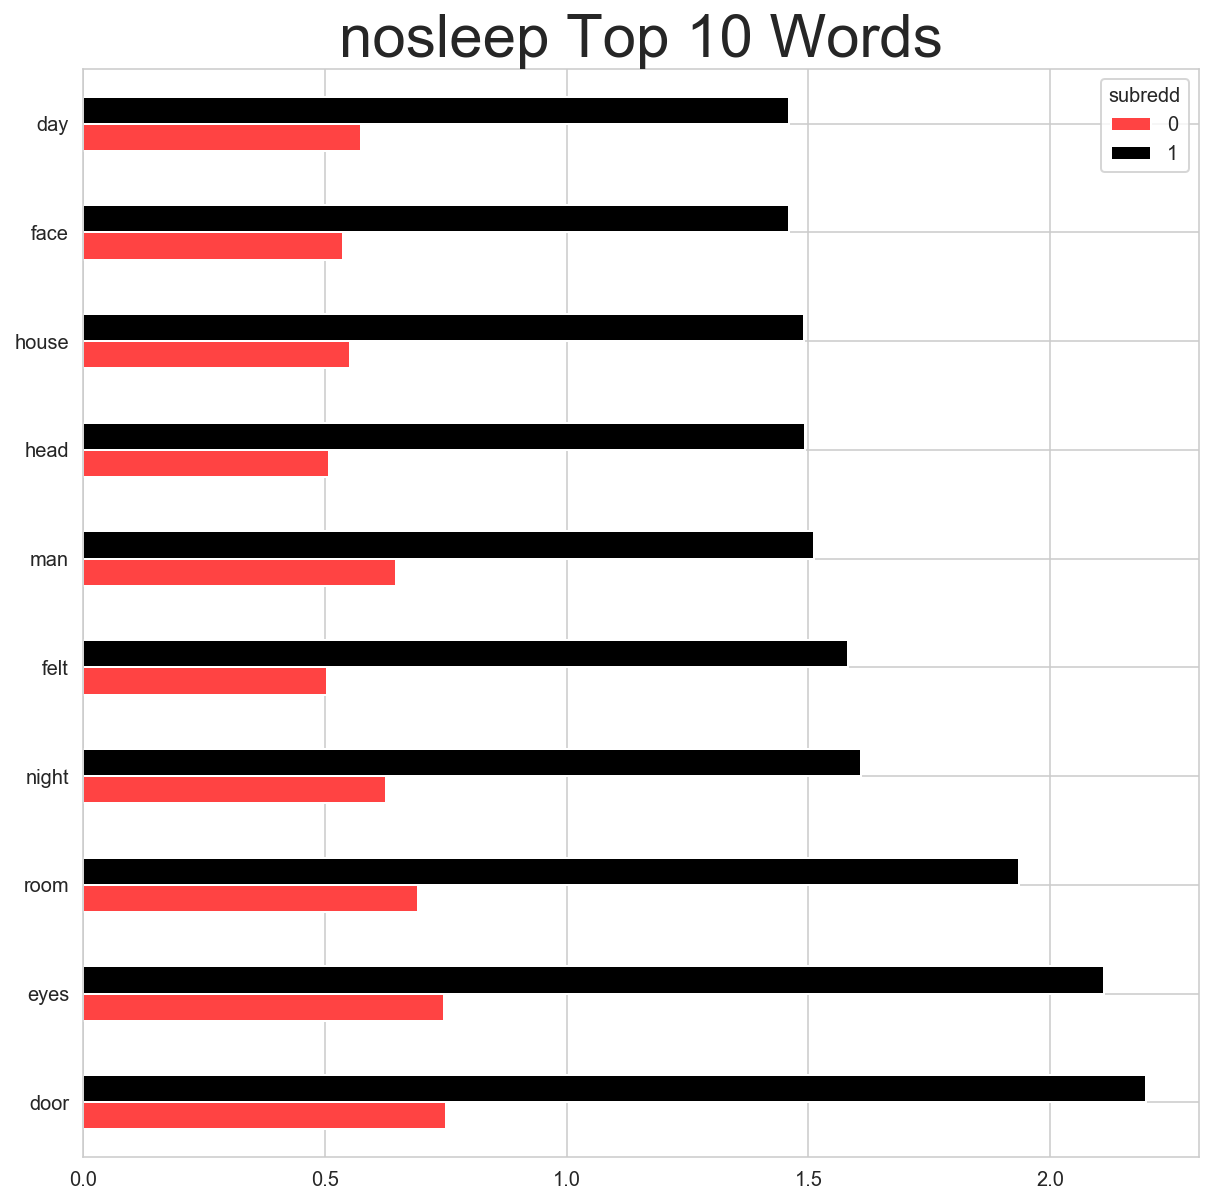

In [155]:
top_words_nosleep.plot(kind='barh', figsize = (10,10), color = ['#FF4343', 'black'])
plt.title('nosleep Top 10 Words', fontsize = 30);

In [156]:
top_words_creepypasta_list = list(text_df.groupby('subredd').
     mean().T.sort_values(0, ascending=False).head(20).index)

top_words_nosleep_list = list(text_df.groupby('subredd').
     mean().T.sort_values(1, ascending=False).head(20).index)

In [157]:
top_words_overlap = [scary for scary in top_words_creepypasta_list if scary in top_words_nosleep_list]


In [158]:
top_words_overlap

['door',
 'eyes',
 'room',
 'man',
 'night',
 'day',
 'house',
 'face',
 'head',
 'felt',
 'people',
 'heard',
 'thing',
 'look',
 'little',
 'told',
 'left']

In [ ]:
top_words_nosleep

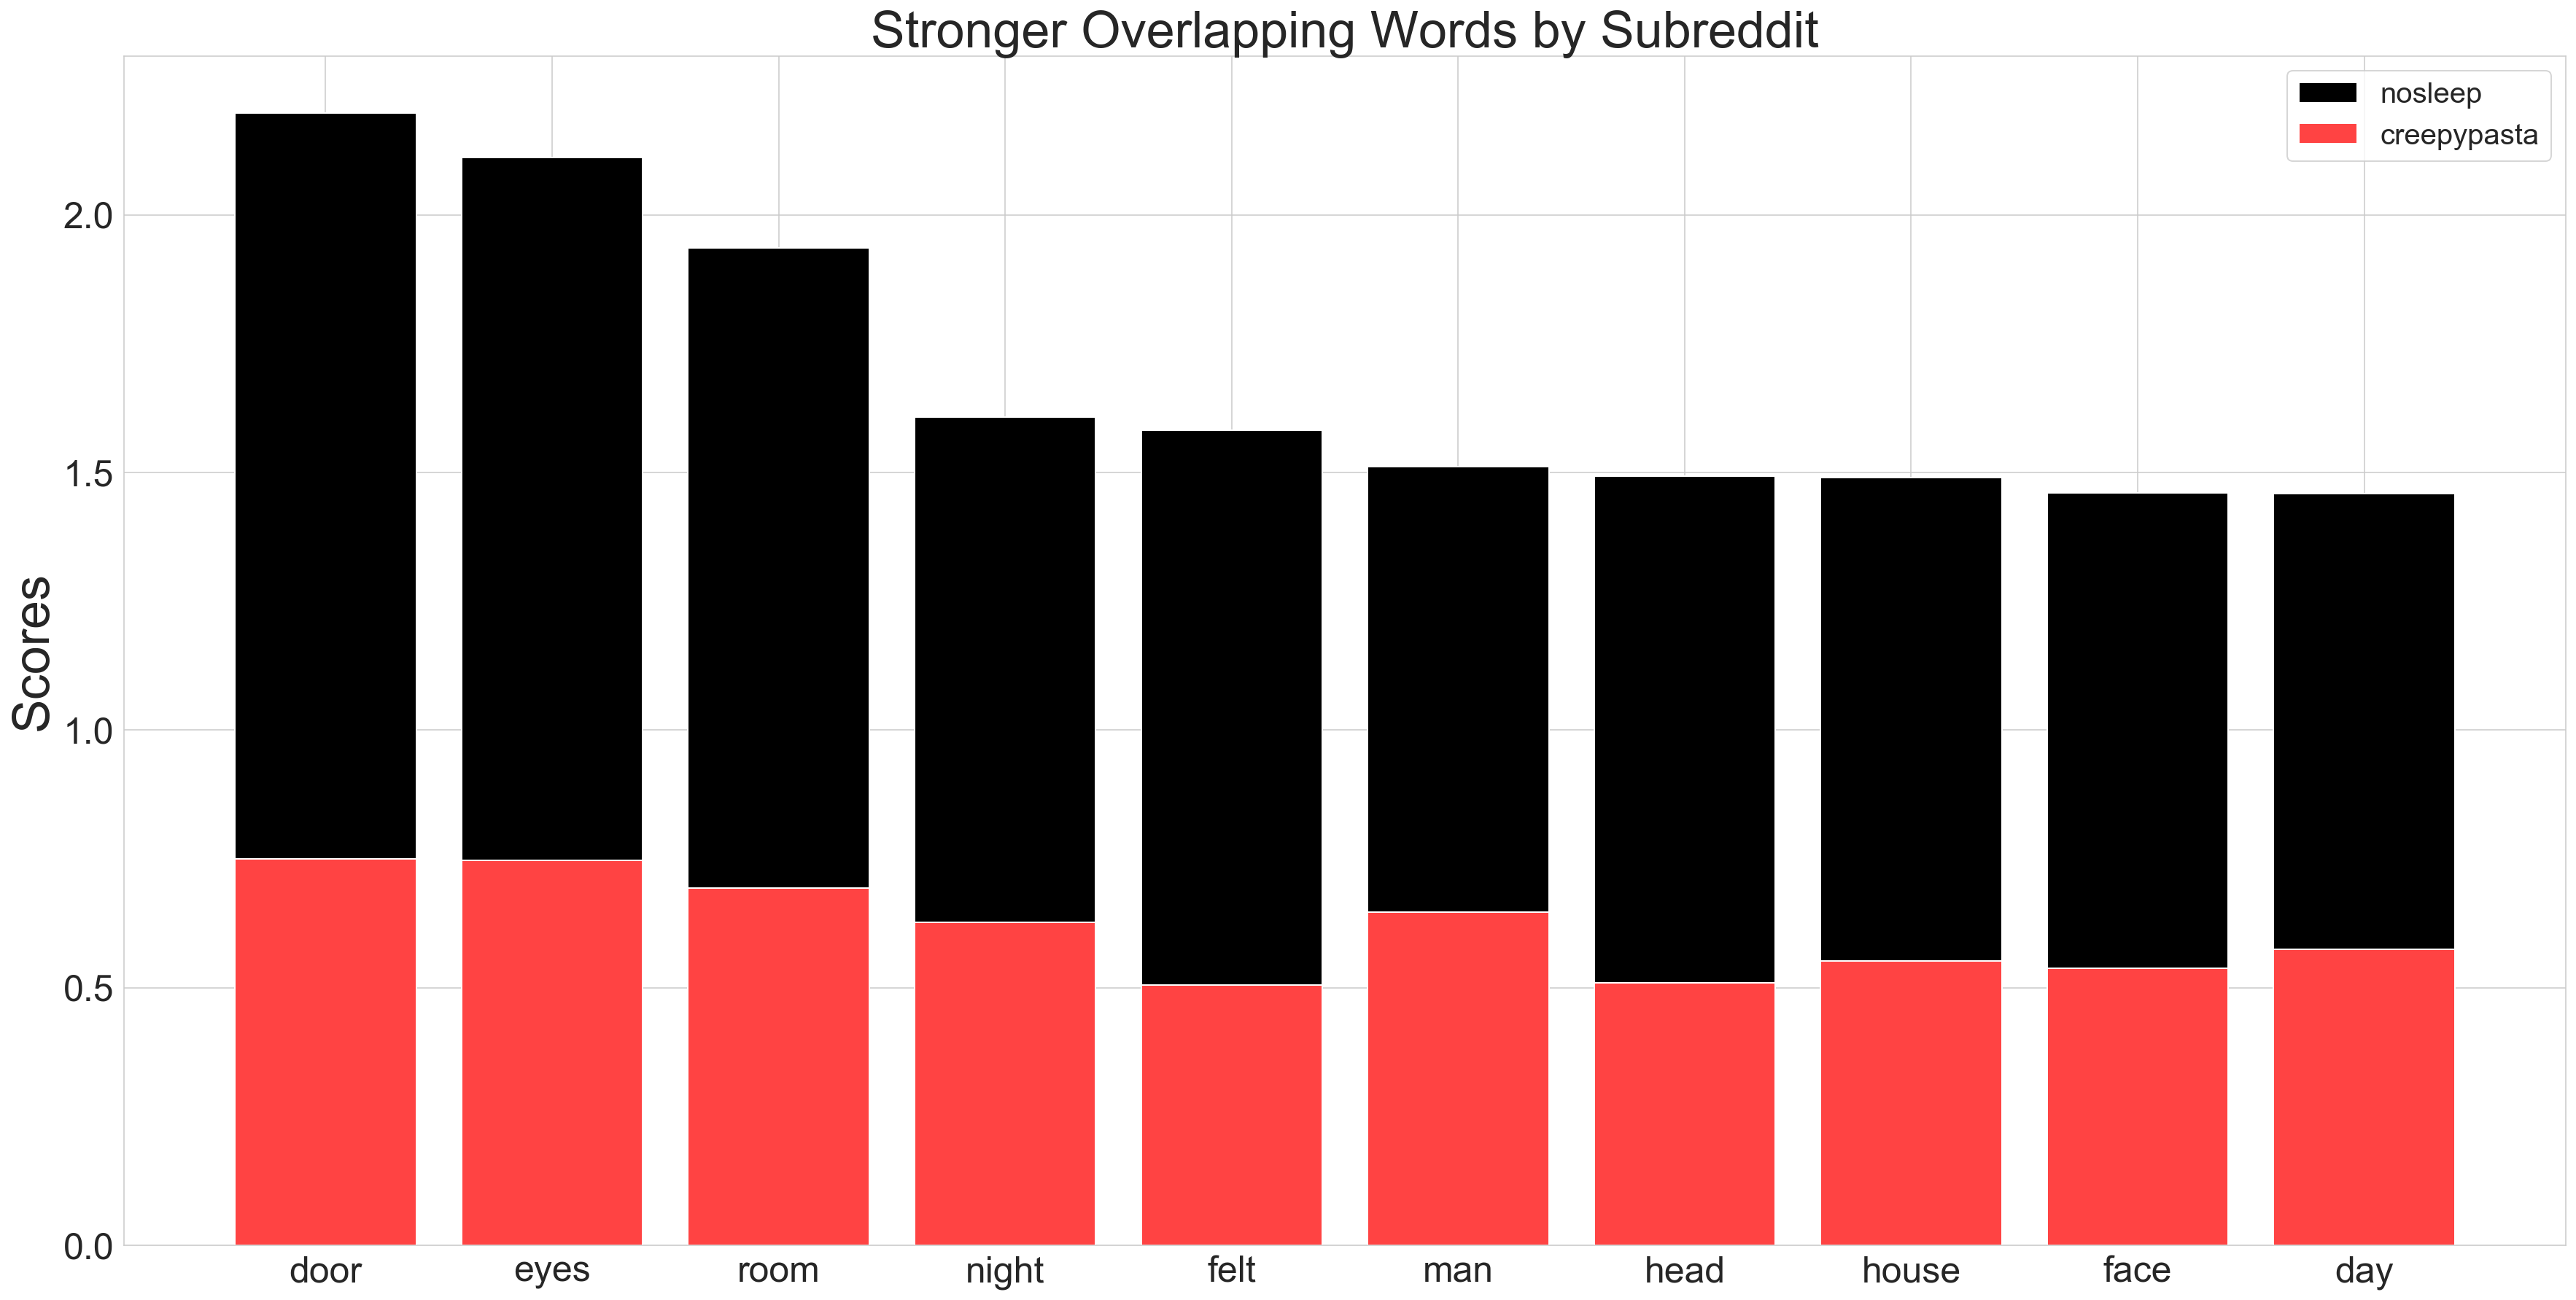

In [170]:
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(30)
rects1 = ax.bar(top_words_nosleep[1].index, top_words_nosleep[1],color='black')
rects2 = ax.bar(top_words_creepypasta[0].index, top_words_creepypasta[0], color='#FF4343')
ax.set_ylabel('Scores', fontsize = 35)
ax.set_title('Stronger Overlapping Words by Subreddit', fontsize = 35)
ax.tick_params(labelsize=25)
ax.legend((rects1[0], rects2[0]), ('nosleep', 'creepypasta'), fontsize =20)